In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import math
import time
from io import StringIO
import sys
import os
import glob
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataset import *
from torch.utils.data import DataLoader

import plottinghelpers

In [2]:
torch.__version__

'1.6.0+cu101'

In [4]:
np.set_printoptions(threshold=sys.maxsize, suppress=True)
torch.set_printoptions(threshold=sys.maxsize, sci_mode=False)

In [5]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print (device)

cuda:2


In [6]:
torch.set_printoptions(sci_mode=False)

In [7]:
root_folder = 'data/simple_reacher/11-04-12-02-44'
number_of_trajectories = 5000
batch_size = 32

In [8]:
print (train_data.trajectory_data.shape)

torch.Size([108673, 9])


In [9]:
print (torch.min(train_data.trajectory_data[:, :1]))
print (torch.max(train_data.trajectory_data[:, :1]))
print (torch.min(train_data.trajectory_data[:, 1:3]))
print (torch.max(train_data.trajectory_data[:, 1:3]))
print (torch.min(train_data.trajectory_data[:, 3:6]))
print (torch.max(train_data.trajectory_data[:, 3:6]))
print (torch.min(train_data.trajectory_data[:, 6:]))
print (torch.max(train_data.trajectory_data[:, 6:]))
# print (torch.min(test_data.trajectory_data[:, :3]))
# print (torch.max(test_data.trajectory_data[:, :3]))
# print (torch.min(test_data.trajectory_data[:, 3:6]))
# print (torch.max(test_data.trajectory_data[:, 3:6]))
# print (torch.min(test_data.trajectory_data[:, 6:]))
# print (torch.max(test_data.trajectory_data[:, 6:]))
print (np.pi)

tensor(-3.1352, device='cuda:2', dtype=torch.float64)
tensor(3.1405, device='cuda:2', dtype=torch.float64)
tensor(-2.8946, device='cuda:2', dtype=torch.float64)
tensor(2.8969, device='cuda:2', dtype=torch.float64)
tensor(-3.1364, device='cuda:2', dtype=torch.float64)
tensor(3.1412, device='cuda:2', dtype=torch.float64)
tensor(-0.1990, device='cuda:2', dtype=torch.float64)
tensor(0.1985, device='cuda:2', dtype=torch.float64)
3.141592653589793


In [10]:
actions = train_data.trajectory_data[:, 6:]
print (actions.shape)
print (torch.max(actions))
print (torch.min(actions))
print (torch.where(torch.abs(actions) <= 0.15)[0].shape)
print (torch.where(torch.abs(actions) > 0.15)[0].shape)
print (torch.unique(torch.where(actions > 0.15)[0]))

torch.Size([108673, 3])
tensor(0.1985, device='cuda:2', dtype=torch.float64)
tensor(-0.1990, device='cuda:2', dtype=torch.float64)
torch.Size([325294])
torch.Size([725])
tensor([  3035,   3036,   3037,   3038,   3039,   3040,   3041,   3042,   4013,
          4014,   4015,   7230,   7768,   7769,   7770,   8058,   8059,   8060,
          8061,   8062,   8063,   8064,   8065,   8066,   8067,   8820,   8821,
          8822,   8823,   8824,  10450,  10451,  10452,  10453,  10454,  10455,
         10506,  10507,  10508,  10509,  10510,  10511,  10656,  10657,  10658,
         10659,  10660,  10661,  10662,  10696,  10697,  10698,  10699,  10700,
         12483,  12484,  12485,  12486,  13834,  13835,  14230,  14231,  14232,
         15638,  15639,  15640,  15641,  15784,  15785,  15786,  15787,  18005,
         18006,  18007,  18008,  18009,  18010,  18011,  19591,  19592,  19593,
         19594,  19595,  19596,  19597,  20891,  20892,  20893,  20894,  20895,
         20896,  20897,  20910

In [38]:
train_data.cumulative_index

tensor([        0.,        24.,        51.,  ...,    108597.,    108627.,
           108648.])

In [40]:
import bisect
rowId = 51
pos = bisect.bisect_left(train_data.cumulative_index.numpy(), rowId)
if train_data.cumulative_index[pos] < rowId:
    pos -= 1
print ('Trajectory containing row index : {} = {}'.format(rowId, pos))

Trajectory containing row index : 51 = 2


In [29]:
def trajectory_goal_error(trajectory):
    return torch.abs(trajectory[-1, :3]-trajectory[-1, 3:6])

In [30]:
traj_errors = torch.zeros(5000, 3)
for i in range(5000):
    traj_errors[i] = trajectory_goal_error(train_data.trajectory_data[torch.where(train_data.trajectory_index[:, 0] == i)[0]])

In [16]:
trajectory = train_data.trajectory_data[torch.where(train_data.trajectory_index == 0)[0]]

In [17]:
print (trajectory[-1, :3])
print (trajectory[-1, 3:6])
print (trajectory_goal_error(trajectory))

tensor([-2.9732, -1.6935, -1.9150], device='cuda:2', dtype=torch.float64)
tensor([-1.0334,  0.0324, -2.4570], device='cuda:2', dtype=torch.float64)
tensor([1.9398, 1.7259, 0.5420], device='cuda:2', dtype=torch.float64)


In [31]:
print(torch.min(traj_errors))
print(torch.max(traj_errors))
print (torch.where(traj_errors > 0.1)[0])
# print (traj_errors[torch.where(traj_errors > 0.15)[0]])

tensor(    0.0000)
tensor(0.0995)
tensor([], dtype=torch.int64)


In [6]:
traj_dataset = SimpleReacherTrajectoryDataset(root_folder, number_of_trajectories, include_images=False, device=device)

In [33]:
for tId in range(5000):
    tData = traj_dataset[tId]['states']
    state_diff = (tData[1:, :3] - tData[:-1, :3])
    if torch.any(torch.abs(state_diff) > 0.1):
        print (tId)
print ('Done')

Done


In [31]:
tData = traj_dataset[1]['states']
state_diff = (tData[1:, :3] - tData[:-1, :3])
torch.abs(state_diff)

tensor([[0.0519, 0.0637, 0.0305],
        [0.0166, 0.0308, 0.0562],
        [0.0227, 0.0423, 0.0815],
        [0.0228, 0.0426, 0.0839],
        [0.0228, 0.0427, 0.0844],
        [0.0228, 0.0427, 0.0845],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846]], device='cuda:2', dtype=torch.float64)

In [6]:
start = time.time()
train_traj_data = SimpleReacherTrajectoryDataset(root_folder, range(500), device=device) #only a subset of training_data
test_traj_data = SimpleReacherTrajectoryDataset(root_folder, range(4750, 5000), device=device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 9.918212890625e-05 sec


In [20]:
last_rows = torch.zeros((len(train_traj_data), 9))
other_rows = None
for i in range(len(train_traj_data)):
    last_rows[i] = train_traj_data[i]['states'][-1]
    if other_rows is not None:
        other_rows = torch.cat((other_rows, train_traj_data[i]['states'][:-1, :]), dim=0)
    else:
        other_rows = train_traj_data[i]['states'][:-1, :]

In [ ]:
last_rows_diff = (last_rows[:, 3:6] - last_rows[:, :3]).cpu()
other_rows_diff = (other_rows[:, 3:6] - other_rows[:, :3]).cpu()

In [9]:
traj_dataset = SimpleReacherTrajectoryDataset(root_folder, range(10), device=device)

In [11]:
new_traj_dataset = SimpleReacherTrajectoryDataset('data/simple_reacher/ImageSize64', range(5), device=device)

In [12]:
t0_i1 = new_traj_dataset[0]['images'][1].reshape(64, 64)
t0_iLast = new_traj_dataset[0]['images'][-1].reshape(64, 64)

In [23]:
t0_iLast

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   

In [24]:
torch.sum(t0_i1 == 127)

tensor(1, device='cuda:2')

In [15]:
last_row = traj_dataset[7]['states'][-1]
goal_dev = last_row[3:6] - last_row[:3]
print (goal_dev)
print (torch.sum(torch.abs(goal_dev)))

tensor([-0.0012, -0.0012,  0.0012], device='cuda:2', dtype=torch.float64)
tensor(0.0036, device='cuda:2', dtype=torch.float64)


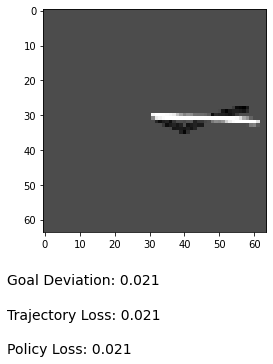

In [36]:
fig = plt.figure(figsize=(4,6))
plt.imshow(t0_i1.cpu().numpy(), cmap='gray')
plt.gcf().text(0.0, 0.16, 'Goal Deviation: 0.021', fontsize=14)
plt.gcf().text(0.0, 0.08, 'Trajectory Loss: 0.021', fontsize=14)
plt.gcf().text(0.0, 0.0, 'Policy Loss: 0.021', fontsize=14)
plt.subplots_adjust(bottom=0.2)
plt.show()

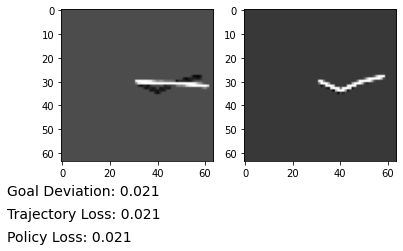

In [45]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(t0_i1.cpu().numpy(), cmap='gray')
ax[1].imshow(t0_iLast.cpu().numpy(), cmap='gray')
plt.gcf().text(0.0, 0.16, 'Goal Deviation: 0.021', fontsize=14)
plt.gcf().text(0.0, 0.08, 'Trajectory Loss: 0.021', fontsize=14)
plt.gcf().text(0.0, 0.0, 'Policy Loss: 0.021', fontsize=14)
plt.subplots_adjust(bottom=0.2)
plt.show()

In [53]:
labels = new_traj_dataset[0]['images']
predictions = labels
errors = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [56]:
plottinghelpers.save_rollout_video(labels, predictions, 'Sample.mp4', 64, 64, errors)

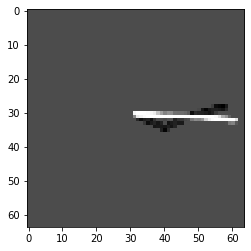

4.0 6.0


In [43]:
fig = plt.figure()
plt.imshow(t0_i1.cpu().numpy(), cmap='gray')
plt.show()
print (fig.get_figheight(), fig.get_figwidth())
plt.close()

In [18]:
last_row = new_traj_dataset[4]['states'][-1]
goal_dev = last_row[3:6] - last_row[:3]
print (goal_dev)
print (torch.sum(torch.abs(goal_dev)))

tensor([ 0.0022, -0.0005,  0.0002], device='cuda:2', dtype=torch.float64)
tensor(0.0030, device='cuda:2', dtype=torch.float64)


In [123]:
new_t4_last_filtered = torch.where(
    torch.bitwise_or(new_t4_last < 136, new_t4_last > 138),
    new_t4_last,
    torch.zeros_like(new_t4_last))

In [124]:
t7_last_filtered = torch.where(
    torch.bitwise_or(t7_last < 136, t7_last > 138),
    t7_last,
    torch.zeros_like(t7_last))

In [27]:
def print_non_zero(ip_tensor):
    for i in range(len(ip_tensor)):
        if torch.sum(ip_tensor[i] > 0):
            print ('{}: {}'.format(i, ip_tensor[i][ip_tensor[i] != 0].cpu().numpy()))

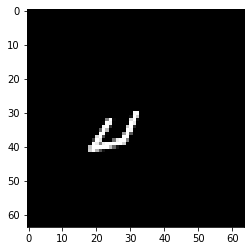

In [26]:
plt.imshow(t0_iLast.cpu().numpy(), cmap='gray')

In [28]:
print_non_zero(t0_iLast)

30: [246 249]
31: [ 17 255 206]
32: [131 255   7 221 255  18]
33: [  7 255 244   1   1 255 235]
34: [247 255  48 205 255  42]
35: [100 255 188 255 245]
36: [255 253   6 156 255  89]
37: [221 255  79 254 252]
38: [ 63 255 231   2 113 238 254 255 131]
39: [254 236 134 241 255 255 255 255 254 212   1]
40: [198 255 255 255 255 254 194 104  23   1]
41: [207 252 178  85  19]


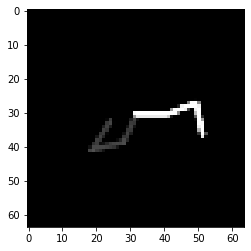

In [25]:
plt.imshow(t0_i1.cpu().numpy(), cmap='gray')

In [29]:
print_non_zero(t0_i1)

26: [3]
27: [127 252 255 135]
28: [ 37 243 255 255 255 255 244]
29: [152 254 255 255 242  70 241 255]
30: [248 255 255 255 255 255 255 255 255 255 255 255 254 136 192 255]
31: [147 232 232 232 232 233 233 233 234 234 202  26  96 255  44]
32: [  6  59  30  63  15  10 255 158]
33: [ 56  69   1  58  54 254 250]
34: [ 32  64  28  21  65  19 239 255]
35: [  2  63  52  55  56 175 255]
36: [ 53  59   6  17  66  30  53 255  81]
37: [ 22  65  36  53  58 234   6]
38: [62 54 11 37 74 40]
39: [47 61 13 18 41 60 68 71 69 76  1]
40: [18 71 71 70 70 66 58 50 23  1]
41: [67 80 57 45 19]


In [42]:
root = 'data/simple_reacher/ImageSize64_ClearBG'
count = 0
for i in range(1000):
    filePath = os.path.join(root, str(i), 'images.npy')
    ip = np.load(filePath)
    if np.any(ip == 126) or np.any(ip == 128):
        print ('Adjacent elements are detected in trajectory {}, further look needed'.format(i))
    op = np.where(ip == 127, np.zeros_like(ip), ip)
    np.save(filePath, op)
    count += 1
print ('Total files processed = {}'.format(count))

Adjacent elements are detected in trajectory 0, further look needed
Adjacent elements are detected in trajectory 1, further look needed
Adjacent elements are detected in trajectory 2, further look needed
Adjacent elements are detected in trajectory 3, further look needed
Adjacent elements are detected in trajectory 4, further look needed
Adjacent elements are detected in trajectory 5, further look needed
Adjacent elements are detected in trajectory 6, further look needed
Adjacent elements are detected in trajectory 7, further look needed
Adjacent elements are detected in trajectory 8, further look needed
Adjacent elements are detected in trajectory 9, further look needed
Adjacent elements are detected in trajectory 10, further look needed
Adjacent elements are detected in trajectory 11, further look needed
Adjacent elements are detected in trajectory 12, further look needed
Adjacent elements are detected in trajectory 13, further look needed
Adjacent elements are detected in trajectory

Adjacent elements are detected in trajectory 155, further look needed
Adjacent elements are detected in trajectory 156, further look needed
Adjacent elements are detected in trajectory 157, further look needed
Adjacent elements are detected in trajectory 158, further look needed
Adjacent elements are detected in trajectory 159, further look needed
Adjacent elements are detected in trajectory 160, further look needed
Adjacent elements are detected in trajectory 161, further look needed
Adjacent elements are detected in trajectory 162, further look needed
Adjacent elements are detected in trajectory 163, further look needed
Adjacent elements are detected in trajectory 164, further look needed
Adjacent elements are detected in trajectory 165, further look needed
Adjacent elements are detected in trajectory 166, further look needed
Adjacent elements are detected in trajectory 167, further look needed
Adjacent elements are detected in trajectory 168, further look needed
Adjacent elements ar

Adjacent elements are detected in trajectory 339, further look needed
Adjacent elements are detected in trajectory 340, further look needed
Adjacent elements are detected in trajectory 341, further look needed
Adjacent elements are detected in trajectory 342, further look needed
Adjacent elements are detected in trajectory 343, further look needed
Adjacent elements are detected in trajectory 344, further look needed
Adjacent elements are detected in trajectory 345, further look needed
Adjacent elements are detected in trajectory 346, further look needed
Adjacent elements are detected in trajectory 347, further look needed
Adjacent elements are detected in trajectory 348, further look needed
Adjacent elements are detected in trajectory 349, further look needed
Adjacent elements are detected in trajectory 350, further look needed
Adjacent elements are detected in trajectory 351, further look needed
Adjacent elements are detected in trajectory 352, further look needed
Adjacent elements ar

Adjacent elements are detected in trajectory 539, further look needed
Adjacent elements are detected in trajectory 540, further look needed
Adjacent elements are detected in trajectory 541, further look needed
Adjacent elements are detected in trajectory 542, further look needed
Adjacent elements are detected in trajectory 543, further look needed
Adjacent elements are detected in trajectory 544, further look needed
Adjacent elements are detected in trajectory 545, further look needed
Adjacent elements are detected in trajectory 546, further look needed
Adjacent elements are detected in trajectory 547, further look needed
Adjacent elements are detected in trajectory 548, further look needed
Adjacent elements are detected in trajectory 549, further look needed
Adjacent elements are detected in trajectory 550, further look needed
Adjacent elements are detected in trajectory 551, further look needed
Adjacent elements are detected in trajectory 552, further look needed
Adjacent elements ar

Adjacent elements are detected in trajectory 733, further look needed
Adjacent elements are detected in trajectory 734, further look needed
Adjacent elements are detected in trajectory 735, further look needed
Adjacent elements are detected in trajectory 736, further look needed
Adjacent elements are detected in trajectory 737, further look needed
Adjacent elements are detected in trajectory 738, further look needed
Adjacent elements are detected in trajectory 739, further look needed
Adjacent elements are detected in trajectory 740, further look needed
Adjacent elements are detected in trajectory 741, further look needed
Adjacent elements are detected in trajectory 742, further look needed
Adjacent elements are detected in trajectory 743, further look needed
Adjacent elements are detected in trajectory 744, further look needed
Adjacent elements are detected in trajectory 745, further look needed
Adjacent elements are detected in trajectory 746, further look needed
Adjacent elements ar

Adjacent elements are detected in trajectory 921, further look needed
Adjacent elements are detected in trajectory 922, further look needed
Adjacent elements are detected in trajectory 923, further look needed
Adjacent elements are detected in trajectory 924, further look needed
Adjacent elements are detected in trajectory 925, further look needed
Adjacent elements are detected in trajectory 926, further look needed
Adjacent elements are detected in trajectory 927, further look needed
Adjacent elements are detected in trajectory 928, further look needed
Adjacent elements are detected in trajectory 929, further look needed
Adjacent elements are detected in trajectory 930, further look needed
Adjacent elements are detected in trajectory 931, further look needed
Adjacent elements are detected in trajectory 932, further look needed
Adjacent elements are detected in trajectory 933, further look needed
Adjacent elements are detected in trajectory 934, further look needed
Adjacent elements ar

In [8]:
def process_arrays(root, total, fileName, array_func, save=False):
    for tId in range(total):
        filePath = os.path.join(root, str(tId), fileName)
        ip = np.load(filePath)
        op = array_func(tId, ip)
        if save:
            np.save(filePath, op)

In [53]:
filtered = []
def filter_arrays(tId, arr):
    if np.any(arr == 128):
        filtered.append(tId)

process_arrays('data/simple_reacher/ImageSize64_ClearBG', 1000, 'images.npy', array_func = filter_arrays, save=False)

In [54]:
len(filtered)

993

In [76]:
def save_trajectory_video(labels, targetFile, img_H, img_W):
    ims = []
    fig = plt.figure()
    for i in range(len(labels)):
        im1 = plt.imshow(labels[i].reshape(img_H, img_W), cmap=plt.get_cmap("gray"))
        ims.append([im1])

    ani = animation.ArtistAnimation(fig, ims, interval=500, repeat=False)
    if len(targetFile) > 0:
        ani.save(targetFile)
    else:
        return ani.to_html5_video()
    plt.close('all')


In [59]:
tId = 10
root = 'data/simple_reacher/ImageSize64_ClearBG'
file = os.path.join(root, str(tId), 'images.npy')
labels = np.load(file)
save_trajectory_video(labels, os.path.join(root, str(tId), 'video.mp4'), 64, 64)

In [114]:
tId = 10
root = 'data/simple_reacher/ImageSize64'
file = os.path.join(root, str(tId), 'images.npy')
labels = np.load(file)
save_trajectory_video(labels, os.path.join(root, str(tId), 'video.mp4'), 64, 64)

In [64]:
labels[labels == 126]

array([126, 126, 126, 126, 126, 126, 126, 126, 126], dtype=uint8)

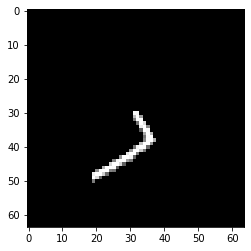

In [77]:
from IPython.display import HTML
HTML(save_trajectory_video(labels, '', 64, 64))

In [111]:
labels_extreme = np.where(np.bitwise_or(labels < 125, labels > 129), labels, np.zeros_like(labels))

In [112]:
labels_extreme[labels_extreme == 141]

array([141, 141, 141, 141, 141], dtype=uint8)

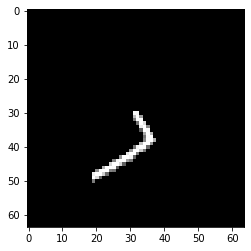

In [113]:
HTML(save_trajectory_video(labels_extreme, '', 64, 64))

In [4]:
rootdir = 'runs/Policies/11-16'
extension = '.mp4'
count = 0
for filename in glob.iglob(rootdir + '/**/*' + extension, recursive=True):
    parent, name = os.path.split(filename)
    run_folder = os.path.basename(os.path.dirname(parent))
    prefix = run_folder[:15]
    newname = prefix + name
    print ('{} --> {}'.format(name, newname))
    print(filename, os.path.join(parent, newname))
    os.rename(filename, os.path.join(parent, newname))
    count += 1
print (count)

traj_78_Highest_Trajectory_Error.mp4 --> 11-16-14-05-36-traj_78_Highest_Trajectory_Error.mp4
runs/Policies/11-16/11-16-14-05-36-ImageSize64_ImageToPolicy-Reacher-Nvidia-L1/TestSet_Evaluations/traj_78_Highest_Trajectory_Error.mp4 runs/Policies/11-16/11-16-14-05-36-ImageSize64_ImageToPolicy-Reacher-Nvidia-L1/TestSet_Evaluations/11-16-14-05-36-traj_78_Highest_Trajectory_Error.mp4
traj_77_Random.mp4 --> 11-16-14-05-36-traj_77_Random.mp4
runs/Policies/11-16/11-16-14-05-36-ImageSize64_ImageToPolicy-Reacher-Nvidia-L1/TestSet_Evaluations/traj_77_Random.mp4 runs/Policies/11-16/11-16-14-05-36-ImageSize64_ImageToPolicy-Reacher-Nvidia-L1/TestSet_Evaluations/11-16-14-05-36-traj_77_Random.mp4
traj_12_Least_Goal_Error.mp4 --> 11-16-14-05-36-traj_12_Least_Goal_Error.mp4
runs/Policies/11-16/11-16-14-05-36-ImageSize64_ImageToPolicy-Reacher-Nvidia-L1/TestSet_Evaluations/traj_12_Least_Goal_Error.mp4 runs/Policies/11-16/11-16-14-05-36-ImageSize64_ImageToPolicy-Reacher-Nvidia-L1/TestSet_Evaluations/11-16-14